# Train baseline model for nodule classification

## Setup environment

### [Optional]: Install dependencies

In [ ]:
!pip install "monai[nibabel,skimage,pillow,tqdm]" pytorch_lightning wandb

### [Optional]: Download data

In [ ]:
!mkdir -p ../data/full/processed ../data/full/cache

In [ ]:
!gsutil cp gs://lung-cancer-detection/lidc-idri/processed/nodules.zip ../data/full/processed

In [ ]:
!gsutil cp gs://lung-cancer-detection/lidc-idri/processed/meta.zip ../data/full/processed

In [ ]:
!gsutil cp gs://lung-cancer-detection/lidc-idri/splits.zip ../data/full/

In [ ]:
!unzip ../data/full/processed/nodules.zip ../data/full/processed

In [ ]:
!unzip ../data/full/processed/meta.zip ../data/full/processed

In [ ]:
!unzip ../data/full/splits.zip ../data/full

## Load modules and configuration

### Import modules

In [1]:
from pathlib import Path

import numpy as np
import wandb
from monai.networks.nets import DenseNet
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

from lung_cancer_detection.data.nodule import ClassificationDataModule
from lung_cancer_detection.models.classification import NoduleClassificationModule
from lung_cancer_detection.utils import load_config, load_json, preview_dataset

### Load configuration file

In [2]:
cp = Path("../configs/local.yaml").absolute()
cp.exists()

True

In [3]:
config = load_config(cp)
config

{'random_seed': 47,
 'wandb': {'offline': False, 'project': 'lung-cancer-detection'},
 'artifacts': {'data': {'name': 'lidc-idri-raw',
   'version': 'v1',
   'type': 'dataset',
   'description': 'Zipped dataset of all chest CT scans, masks and nodule volumes in npy format, including scan and nodule metadata. Updated with new volume size for nodules.'},
  'train': {'name': 'lidc-train',
   'version': 'v1',
   'type': 'dataset',
   'description': 'List of patient IDs included in the training set'},
  'valid': {'name': 'lidc-valid',
   'version': 'v1',
   'type': 'dataset',
   'description': 'List of patient IDs included in the validation set'},
  'class_model': {'name': 'nodule-classification-model',
   'version': 'v0',
   'type': 'model',
   'description': 'Basic DenseNet for classifying lung nodules regarding their malignancy'},
  'seg_model': {'name': 'nodule-segmentation-model',
   'version': 'v1',
   'type': 'model',
   'description': 'Basic UNet for segmenting lung nodules in chest

## Initialize datasets

### Create data module

In [4]:
splits = [
    load_json(Path(config["data"]["split_dir"])/"train.json"), 
    load_json(Path(config["data"]["split_dir"])/"valid.json")
]
label_mapping = ([1,2,3,4,5], [0,0,0,1,1])

In [5]:
dm = ClassificationDataModule(
    data_dir=Path(config["data"]["data_dir"]),
    cache_dir=(Path()/"../data/cache/").absolute(),
    splits=splits,
    min_anns=3,
    exclude_labels=[],
    label_mapping=label_mapping,
    batch_size=config["data"]["batch_size"]
)

In [6]:
dm.setup()

### Preview datasets

#### Dataset statistics

In [7]:
print(f"Number of training examples: {len(dm.train_ds)}")
print(f"Number of validation examples: {len(dm.val_ds)}")

Number of training examples: 1120
Number of validation examples: 259


In [8]:
train_labels = np.concatenate([image["label"].numpy() for image in dm.train_ds])
valid_labels = np.concatenate([image["label"].numpy() for image in dm.val_ds])

In [9]:
print(np.unique(train_labels))

[0. 1.]


In [10]:
print(f"Percentage of malignant training nodules: {np.mean(train_labels):.4f}")
print(f"Percentage of malignant training nodules: {np.mean(valid_labels):.4f}")

Percentage of malignant training nodules: 0.3232
Percentage of malignant training nodules: 0.3127


#### Example images

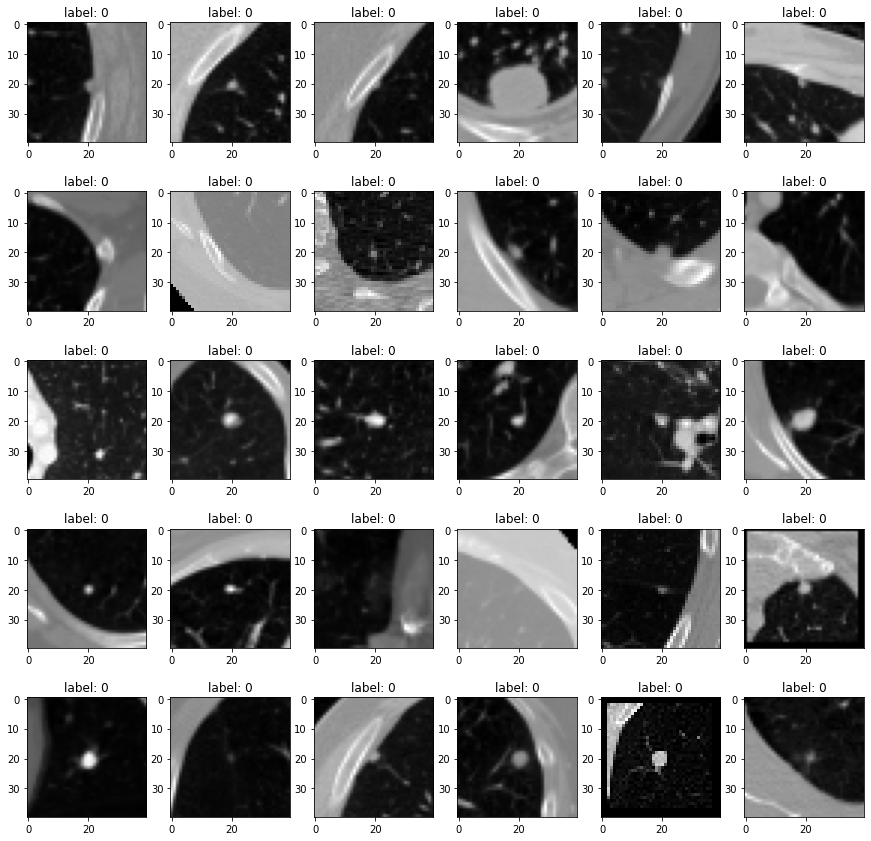

In [11]:
preview_dataset(dm.query_by_label(split="train", n=30, labels=[0]))

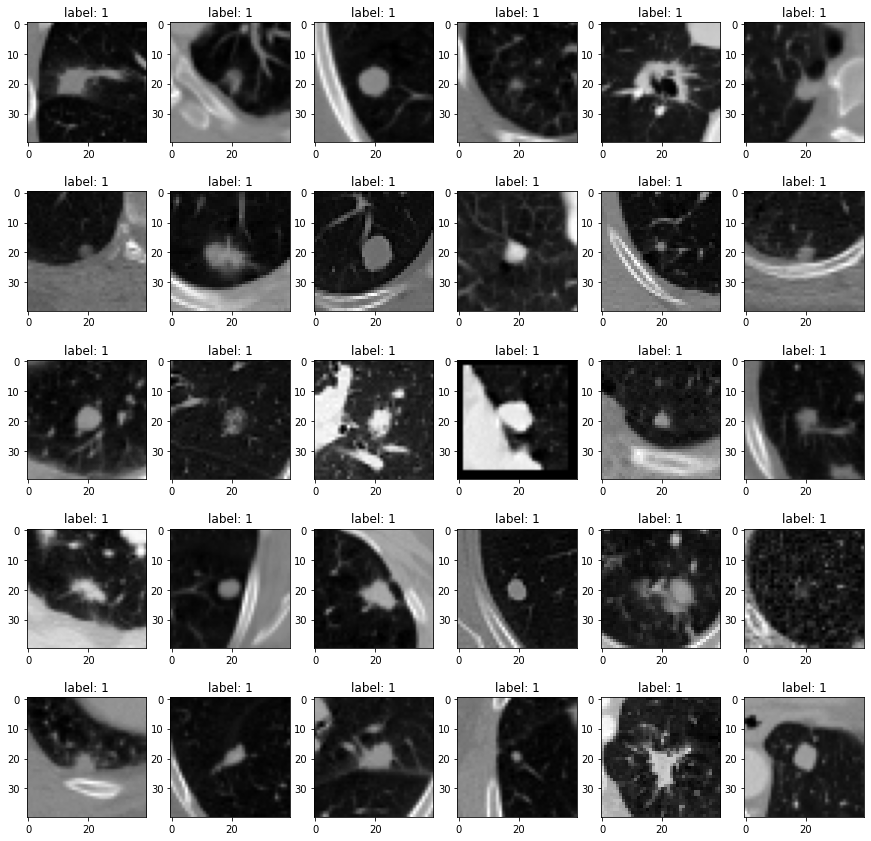

In [12]:
preview_dataset(dm.query_by_label(split="train", n=30, labels=[1]))

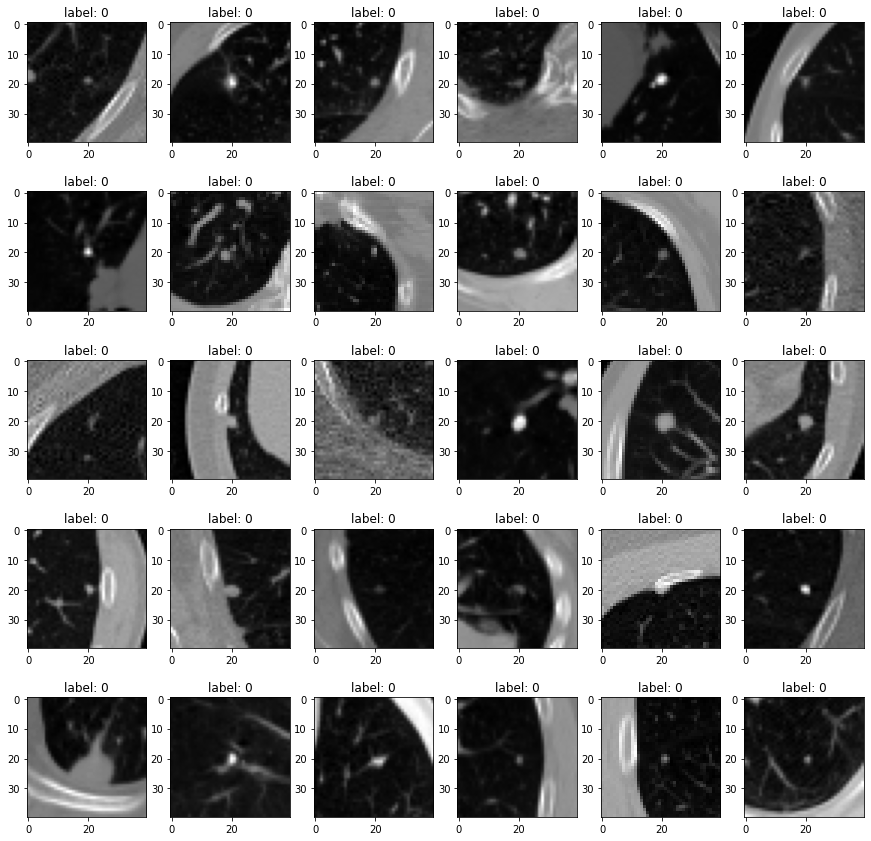

In [13]:
preview_dataset(dm.query_by_label(split="valid", n=30, labels=[0]))

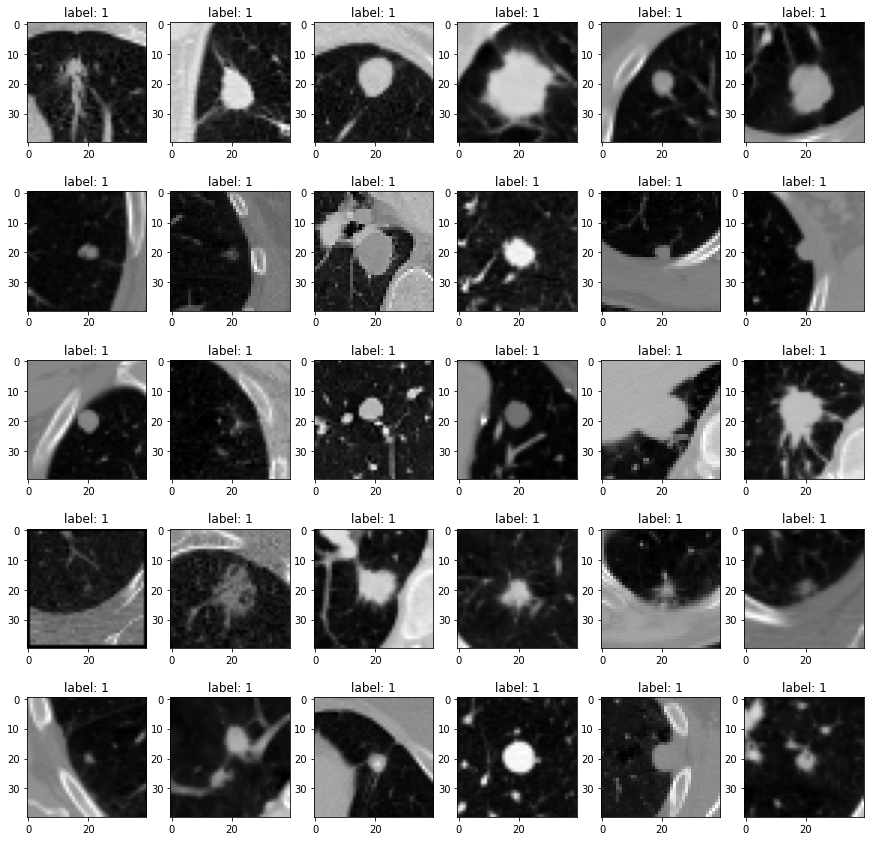

In [14]:
preview_dataset(dm.query_by_label(split="valid", n=30, labels=[1]))

## Initialize model

In [15]:
net = DenseNet(
    spatial_dims=config["class_model"]["spatial_dims"],
    in_channels=config["class_model"]["in_channels"],
    out_channels=config["class_model"]["out_channels"],
)

In [16]:
model = NoduleClassificationModule(net, num_classes=config["class_model"]["num_classes"])

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.


## Validation check: overfit one batch

In [17]:
trainer = Trainer(auto_select_gpus=True, overfit_batches=1, max_epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [18]:
trainer.fit(model, datamodule=dm)


  | Name      | Type     | Params
---------------------------------------
0 | model     | DenseNet | 11.2 M
1 | train_acc | Accuracy | 0     
2 | val_acc   | Accuracy | 0     
3 | train_auc | AUROC    | 0     
---------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.979    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

You requested to overfit but enabled val/test dataloader shuffling. We are turning it off for you.
You requested to overfit but enabled training dataloader shuffling. We are turning it off for you.


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Run experiment

### Configure experiment

### Find optimal batch size and learning rate

### Train model